In [2]:
!git clone https://github.com/datdefboi/plants-health-detector

Cloning into 'plants-health-detector'...
remote: Enumerating objects: 1014, done.
remote: Counting objects: 100% (1014/1014), done.
remote: Compressing objects: 100% (1003/1003), done.
remote: Total 1014 (delta 17), reused 997 (delta 6), pack-reused 0
Receiving objects: 100% (1014/1014), 55.76 MiB | 47.26 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [3]:
from tensorflow.python.client import device_lib

local_device_protos = device_lib.list_local_devices()
[x.physical_device_desc for x in local_device_protos if x.device_type == 'GPU']

['device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5']

In [4]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

## Препроцессинг

In [5]:
from glob import glob
import numpy as np
import pandas as pd
import os
import shutil 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

## Загрузка изображений

In [6]:
images = []
diseases = []
for culture in glob("plants-health-detector/dataset/*"):
    for disease in glob(culture+"/*"):
        for s in glob(disease+"/*"):
            img = img_to_array(load_img(s, target_size=(224,224))) 
            diseases.append(culture.split('/')[-1]+"-"+disease.split('/')[-1])
            images.append(img)

images = np.array(images)
diseases = np.array(diseases)
images.shape, diseases.shape

((934, 224, 224, 3), (934,))

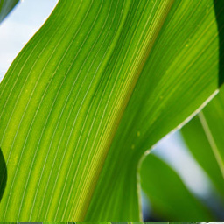

In [7]:
array_to_img(images[0])

## генерация аугментированных изображений

In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
X_train, X_test, C_train, C_test = train_test_split(preprocess_input(np.array(images)), diseases, train_size=0.8, test_size=0.2, random_state=777) # поменял на исходные изображения

In [9]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

de = LabelEncoder()
num_train_labels = de.fit_transform(C_train)
cat_train_labels = to_categorical(num_train_labels)

num_test_labels = de.fit_transform(C_test)
cat_test_labels = to_categorical(num_test_labels)

In [10]:
images_gen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=90,
    horizontal_flip=True)

flow = images_gen.flow(X_train,cat_train_labels)

In [11]:
gen_count = 100
gen_images = []
gen_labels = []
for i in range(gen_count):
    x,y = flow.next()
    gen_images.append(x)
    gen_labels.append(y)
gen_images = np.concatenate(gen_images)
gen_labels = np.concatenate(gen_labels)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [12]:
print(f"Сгенерировано {gen_images.shape[0]} изображений")

Сгенерировано 3116 изображений


## подготовка данных и разбиение выборки 

## Обучение

In [13]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, Input, concatenate 
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

In [21]:
labels_count = np.unique(num_test_labels).size
labels_count

25

In [22]:

restnet = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3)) # загружаем предобученную сеть

output = restnet.layers[-1].output # используем выход пердыдущего слоя
restnet_output = Model(restnet.input, outputs=[output]) # создаем это все дело как модель
for layer in restnet.layers: # замораживаем предобученные слои модели
    layer.trainable = False

#C_input = Input(shape=(C.shape[1]))

conv = Conv2D(600, (5,5))(restnet_output.output)
res_pooling = MaxPooling2D((3,3))(conv)
flat = Flatten()(res_pooling)

#concat_l = concatenate([C_input, flat])

dense_1 = Dense(128, activation='sigmoid')(flat)
drop_1 = Dropout(0.3)(dense_1)
dense_3 = Dense(labels_count, activation='sigmoid')(drop_1)

model = Model(inputs=[restnet_output.input], outputs=[dense_3])
model.compile(loss='categorical_crossentropy', # лейблы кодируются в one-hot
                  optimizer=optimizers.RMSprop(lr=2e-5), # sgd с тюнингом
                  metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [23]:
!nvidia-smi

Tue Mar  2 20:58:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    33W /  70W |    750MiB / 15109MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [25]:
import datetime

history = model.fit(gen_images, gen_labels,
                    epochs=5,
                    steps_per_epoch=200,
                    validation_steps=30,
                    validation_data=(X_test, cat_test_labels),
                    verbose=1)

Epoch 1/5
200/200 [==============================] - 14s 68ms/step - loss: 2.0126 - accuracy: 0.4665 - val_loss: 1.7193 - val_accuracy: 0.4920
Epoch 2/5
200/200 [==============================] - 11s 55ms/step - loss: 1.0765 - accuracy: 0.8251
Epoch 3/5
200/200 [==============================] - 11s 55ms/step - loss: 0.6766 - accuracy: 0.9456
Epoch 4/5
200/200 [==============================] - 11s 55ms/step - loss: 0.4618 - accuracy: 0.9840
Epoch 5/5
200/200 [==============================] - 10s 48ms/step - loss: 0.3331 - accuracy: 0.9946


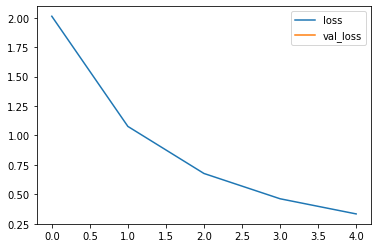

In [29]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss","val_loss"])

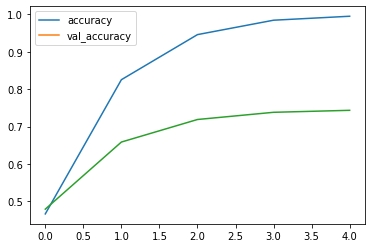

In [30]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.plot((np.array(history.history["val_accuracy"])+np.array(history.history["accuracy"]))/2)
plt.legend(["accuracy","val_accuracy"])

# Анализ результатов

In [26]:
def predict(n):
    img = preprocess_input(np.array([images[n]]))
    predicted = np.argmax(model.predict(img))
    plt.imshow(images[n].astype("int"))
    actual = np.argmax(D[n])
    return de.inverse_transform([predicted, actual])

In [31]:
def find_failed():
    transformed = preprocess_input(np.array(images))
    predicted = model.predict(transformed)
    for i in range(predicted.shape[0]):
        p = de.inverse_transform([np.argmax(predicted[i])])[0]
        a = diseases[i]
        if(p!=a):
            print((i,a,p))

In [32]:
print("id, predicted, actual")
find_failed()

id, predicted, actual
(1, 'Corn-Healthy', 'Wheat-Yellow rust')
(32, 'Corn-Healthy', 'Wheat-Healthy')
(36, 'Corn-Downy mildew', 'Corn-Healthy')
(37, 'Corn-Downy mildew', 'Corn-Healthy')
(38, 'Corn-Downy mildew', 'Wheat-Yellow rust')
(39, 'Corn-Downy mildew', 'Corn-Healthy')
(42, 'Corn-Downy mildew', 'Wheat-Yellow rust')
(43, 'Corn-Downy mildew', 'Corn-Northern leaf blight')
(44, 'Corn-Downy mildew', 'Corn-Northern leaf blight')
(48, 'Corn-Downy mildew', 'Corn-Healthy')
(53, 'Corn-Downy mildew', 'Corn-Healthy')
(56, 'Corn-Downy mildew', 'Wheat-Black chaff')
(63, 'Corn-Downy mildew', 'Corn-Eyespot')
(83, 'Corn-Northern leaf blight', 'Corn-Healthy')
(97, 'Corn-Northern leaf blight', 'Wheat-Black chaff')
(101, 'Corn-Eyespot', 'Corn-Southern rust')
(108, 'Corn-Eyespot', 'Wheat-Yellow rust')
(119, 'Corn-Eyespot', 'Corn-Southern rust')
(126, 'Corn-Eyespot', 'Corn-Healthy')
(127, 'Corn-Eyespot', 'Corn-Healthy')
(128, 'Corn-Eyespot', 'Corn-Northern leaf blight')
(145, 'Corn-Southern rust', 'Whea

In [33]:
def get_by_name(name):
    return list(filter(lambda x: x[1] == name, enumerate(diseases)))

In [34]:
get_by_name('Cotton-Healthy')[0][0]

333

In [35]:
def draw(id):
    plt.figure()
    plt.title(diseases[id])
    plt.imshow(images[id].astype("int")[:,:])

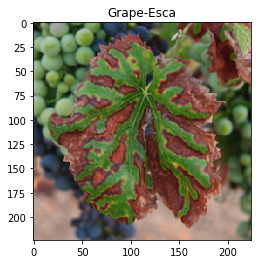

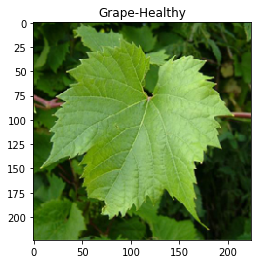

In [36]:
draw(get_by_name('Grape-Esca')[1][0])
draw(get_by_name('Grape-Healthy')[1][0])

In [37]:
pl1 = images[get_by_name('Grape-Esca')[1][0]].astype("int")

(<matplotlib.image.AxesImage at 0x7f82e636de50>,)

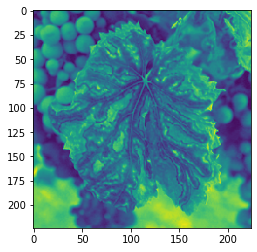

In [38]:
plt.imshow(pl1[:,:,0]),

In [39]:
yellow = pl1[:,:,1]-pl1[:,:,2]

In [40]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

In [42]:
def minmax(a):
    flat = yellow.reshape((yellow.size,1))
    return min_max_scaler.fit_transform(flat).reshape(yellow.shape)

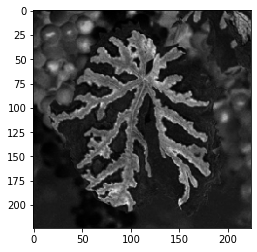

In [48]:
a = minmax(yellow)
plt.imshow(a*minmax(pl1[:,:,1]), cmap="gray")